# get_rdps

This routine grabs the latest Regional Deterministic Prediction System (RDPS) model data from MSC Datamart and outputs png plots into designated product folders for each ACMWF product.

**Datamart:**

https://eccc-msc.github.io/open-data/msc-data/nwp_rdps/readme_rdps_en/

https://dd.weather.gc.ca/model_gem_regional/

**Outputs:**

12hr Total Precipitation -> *BC/AB*

Winds -> *Surface R, 1500m, 2500m*

Surface Maps -> 0-48 Hours

Temperatures -> Freezing Level R

**Maintenance:**

For bug reports, suggestions, inquiries, contact Andrew.Loeppky@gmail.com

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    plot_cities,
    make_figure,
    make_basemap,
    make_title,
)

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
def plot_precip12hr(fxx, ds, config):
    """
    plots 1hr precip, saves hourly to the BC/AB, south coast,
    south interior, alberta rockies folders
    """
    fig, ax = make_figure()

    # basemap
    make_basemap(ax)

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#90EE90",
            "#ADFF2F",
            "#3CB371",
            "#2E8B57",
            "#FFFF00",
            "#FFA500",
            "#E9967A",
            "#B22222",
            "#8B008B",
        ]
    )
    pr_bounds = [1, 2.5, 5, 15, 25, 50, 75, 100, 150, 200]
    pr_labels = ["1", "2.5", "5", "15", "25", "50", "75", "100", "150", "200+"]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds["APCP-Accum12h"].where(ds["APCP-Accum12h"] >= 1),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # precip colorbar
    fig.text(0.151, 0.699, "(mm)", color="black", size=10)
    fig.text(0.15, 0.7, "(mm)", color="white", size=10)

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.45,
        location="left",
        aspect=10,
        anchor=(0.15, 0.45),
        pad=-0.16,
    )
    pr_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    pr_cbar.ax.set_yticklabels(pr_labels)

    # cities
    plot_cities(ax)

    # title
    make_title(fig, ax, ds, "Total Precip - 12h", offset=0.04)

    # BC/AB
    ax.set_extent([-140, -110, 46, 65])
    fig.savefig(
        os.path.join(
            config["plots"]["12hpcp_bcab"],
            f"pcp12hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )

    fig.clf()

    return None

In [3]:
def plot_surf(fxx, ds, config):
    """
    plots the surface figure for mwf day 3-4, surface 0-48h
    """
    fig, ax = make_figure()
    ax.set_extent([-155, -117, 40, 64])

    # basemap
    make_basemap(ax)

    # plot height contours
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.prmsl,
        colors="k",
        transform=pc,
        levels=range(900, 1100, 4),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot thickness contours
    th_cmap = mpl.colors.ListedColormap(
        [
            "pink",
            "blue",
            "orange",
        ]
    )
    th_bounds = [4800, 5100, 5400, 5700]
    th_norm = mpl.colors.BoundaryNorm(th_bounds, th_cmap.N)
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.thick,
        cmap=th_cmap,
        norm=th_norm,
        linestyles="dashed",
        transform=pc,
        levels=range(4000, 6000, 60),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot cloud cover
    cc_cmap = mpl.colors.ListedColormap(["#DCDCDC", "#808080"])
    cc_bounds = [60, 80, 100]
    cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
    cc = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.TCDC.where(ds.TCDC >= 60),
        cmap=cc_cmap,
        norm=cc_norm,
        antialiased=True,
        transform=pc,
    )

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#90EE90",
            "#ADFF2F",
            "#3CB371",
            "#2E8B57",
            "#FFFF00",
            "#FFA500",
            "#B22222",
            "#8B008B",
        ]
    )
    pr_bounds = [1, 2, 5, 10, 20, 30, 50, 75, 100]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.prate.where(ds.prate >= 1),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # precip colorbar
    fig.text(0.121, 0.649, "6hr Pcpn", color="black", size=10)
    fig.text(0.12, 0.65, "6hr Pcpn", color="white", size=10)

    fig.text(0.121, 0.639, "(mm)", color="black", size=10)
    fig.text(0.12, 0.64, "(mm)", color="white", size=10)

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.25,
        location="left",
        aspect=10,
        anchor=(0.15, 0.55),
        pad=-0.15,
    )
    pr_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    # cloud cover colorbar
    fig.text(0.121, 0.399, "Cloud Cover", color="black", size=10)
    fig.text(0.12, 0.40, "Cloud Cover", color="white", size=10)

    fig.text(0.121, 0.389, "(%)", color="black", size=10)
    fig.text(0.12, 0.39, "(%)", color="white", size=10)

    cc_cbar = fig.colorbar(
        cc,
        cmap=cc_cmap,
        norm=cc_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.125,
        location="left",
        aspect=5,
        anchor=(0.15, 0.25),
        pad=-0.18,
    )
    cc_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    make_title(fig, ax, ds, "Surface", offset=0.03)

    # save and close the figure
    fig.savefig(
        os.path.join(
            config["plots"]["surf"],
            f"surf_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    return None

In [ ]:
def do_rdps(run, fxx, config):
    """
    creates all rdps dependent plots for forecast time fxx
    """
    # clear the rdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]
    # heights to pull geopotentials
    hgt = ["ISBL_1000", "ISBL_500"]

    # get all the data and merge it into one big xarray
    temp = get_var(run, "rdps", fxx, "TMP", "TGL_2")
    tcdc = get_var(run, "rdps", fxx, "TCDC", "SFC_0")
    prate = get_var(run, "rdps", fxx, "PRATE", "SFC_0")
    height = xr.concat(
        [get_var(run, "rdps", fxx, "HGT", h) for h in hgt], dim="isobaricInhPa"
    )
    pres = get_var(run, "rdps", fxx, "PRMSL", "MSL_0")
    fl = get_var(run, "rdps", fxx, "LHTFL", "SFC_0")

    # 12hr accumulation after forecast hour 12 in 6 hr increments
    if (fxx >= 12) and (fxx % 6 == 0):
        pcp12h = get_var(run, "rdps", fxx, "APCP-Accum12h", "SFC_0")
        ds = xr.merge([temp, tcdc, prate, height, pres, fl, pcp12h])
    else:
        ds = xr.merge([temp, tcdc, prate, height, pres, fl])

    # convert precip from kg/m3/s to mm/6h
    ds["prate"] *= 3600 * 6

    # convert sea level pressure to hPa
    ds["prmsl"] /= 100

    # convert temps from kelvin to degC
    # ds["t"] -= 273.15

    # calculate 1000 - 500mb thickness
    ds["thick"] = ds.gh.loc[{"isobaricInhPa": 500}] - ds.gh.loc[{"isobaricInhPa": 1000}]

    # generate plots
    plot_surf(fxx, ds, config)
    if (fxx >= 12) and (fxx % 6 == 0):
        plot_precip12hr(fxx, ds, config)

    return None

In [13]:
def main(tstep=range(1, 49, 1)):
    """
    main function to generate all rdps plots for a forecast run
    (default 48h with 1h increments)
    """
    # time of last model run (0000, 0600, 1200, 1800 Z)
    now = pd.Timestamp.utcnow().floor("12h").tz_localize(None)

    # config determines the directories in which to save each graphic
    with open("..//config/rdps_config.json") as f:
        config = json.load(f)

    clear_dir = [clear_directory(file) for file in list(config["plots"].values())]
    hrdps = [do_rdps(now, fxx, config) for fxx in tstep]

    return None

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250607]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250607]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250607]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F16 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250607]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F16 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F16 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F16 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12

KeyboardInterrupt: 

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

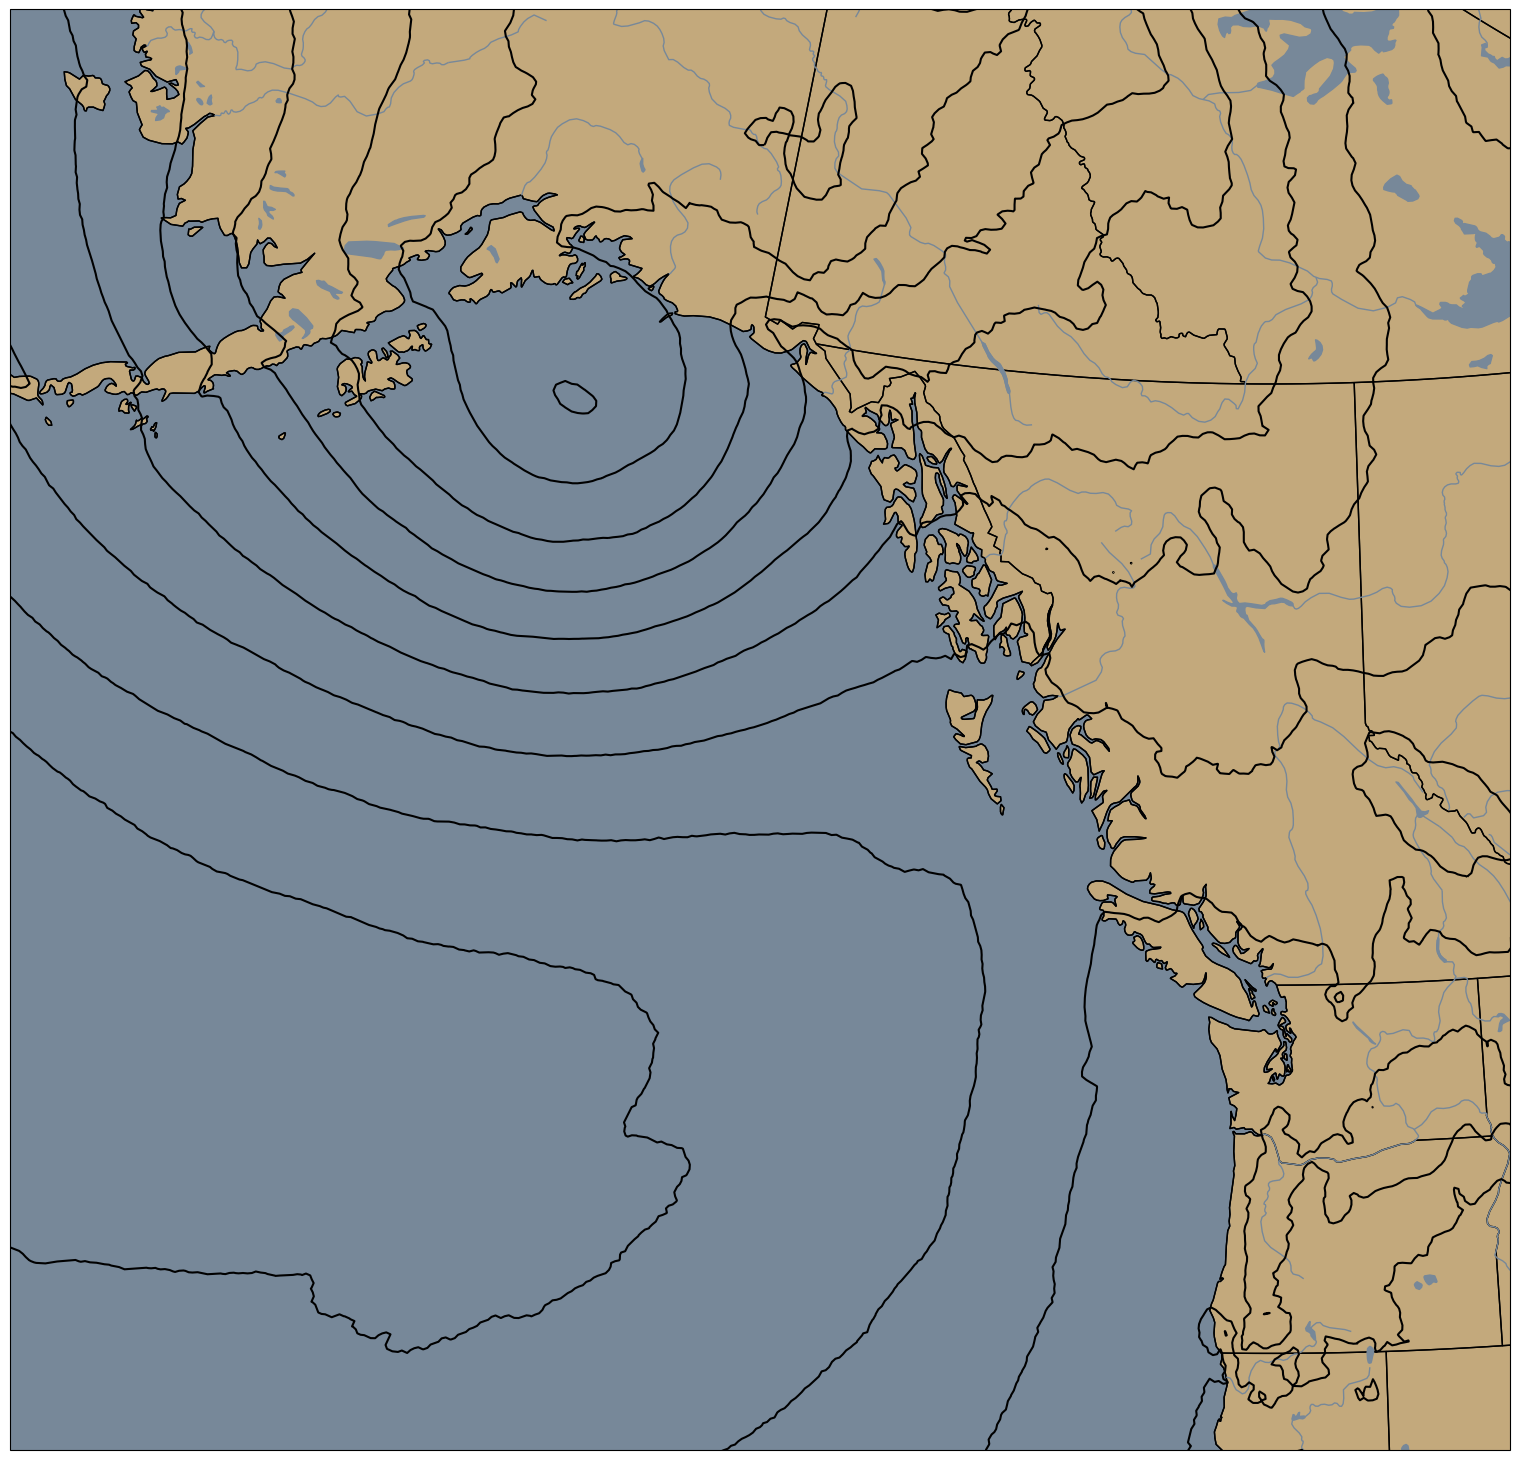

In [18]:
if __name__ == "__main__":
    main()

In [22]:
# time of last model run (0000, 0600, 1200, 1800 Z)
run = pd.Timestamp.utcnow().floor("12h").tz_localize(None)

fxx = 2

# config determines the directories in which to save each graphic
with open("..//config/rdps_config.json") as f:
    config = json.load(f)

clear_dir = [clear_directory(file) for file in list(config["plots"].values())]

# clear the rdps data folder
clear_dir = [clear_directory(file) for file in list(config["data"].values())]
# heights to pull geopotentials
hgt = ["ISBL_1000", "ISBL_500"]

# get all the data and merge it into one big xarray
temp = get_var(run, "rdps", fxx, "TMP", "TGL_2")
tcdc = get_var(run, "rdps", fxx, "TCDC", "SFC_0")
prate = get_var(run, "rdps", fxx, "PRATE", "SFC_0")
height = xr.concat(
    [get_var(run, "rdps", fxx, "HGT", h) for h in hgt], dim="isobaricInhPa"
)
pres = get_var(run, "rdps", fxx, "PRMSL", "MSL_0")
fl = get_var(run, "rdps", fxx, "KX", "SFC_0")

# 12hr accumulation after forecast hour 12 in 6 hr increments
if (fxx >= 12) and (fxx % 6 == 0):
    pcp12h = get_var(run, "rdps", fxx, "APCP-Accum12h", "SFC_0")
    ds = xr.merge([temp, tcdc, prate, height, pres, fl, pcp12h])
else:
    ds = xr.merge([temp, tcdc, prate, height, pres, fl])

# convert precip from kg/m3/s to mm/6h
ds["prate"] *= 3600 * 6

# convert sea level pressure to hPa
ds["prmsl"] /= 100

# convert temps from kelvin to degC
# ds["t"] -= 273.15

# calculate 1000 - 500mb thickness
ds["thick"] = ds.gh.loc[{"isobaricInhPa": 500}] - ds.gh.loc[{"isobaricInhPa": 1000}]

ds

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250607]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


<xarray.Dataset> Size: 37MB
Dimensions:              (y: 824, x: 935, isobaricInhPa: 2)
Coordinates:
    time                 datetime64[ns] 8B 2025-06-07T12:00:00
    step                 timedelta64[ns] 8B 02:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 6MB 18.15 18.18 18.21 ... 45.49 45.41
    longitude            (y, x) float64 6MB 217.1 217.2 217.2 ... 349.8 349.8
    valid_time           datetime64[ns] 8B 2025-06-07T14:00:00
    gribfile_projection  object 8B None
    surface              float64 8B 0.0
  * isobaricInhPa        (isobaricInhPa) float64 16B 1e+03 500.0
    meanSea              float64 8B 0.0
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 3MB ...
    TCDC                 (y, x) float32 3MB ...
    prate                (y, x) float32 3MB 0.0 0.0 0.0 ... 1.296 1.296 0.648
    gh                   (isobaricInhPa, y, x) float32 6MB 116.4 ... 5.788e+03
    prmsl                (y, x) float32 3MB 1.013e+03 1.013e+03 ... 1.018e+03
    kx                   (y, x) float32 3MB ...
    thick                (y, x) float32 3MB 5.758e+03 5.758e+03 ... 5.635e+03
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    model:                   rdps
    product:                 10km/grib2/
    description:             Canada's Regional Deterministic Prediction Syste...
    remote_grib:             /Users/andrew/data/rdps/20250607/CMC_reg_TMP_TGL...
    local_grib:              /Users/andrew/data/rdps/20250607/CMC_reg_TMP_TGL...
    search:                  None

In [31]:
ds = get_var(run, "rdps", fxx, "TSLSA", "SFC_0")
ds

💔 Did not find ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-07 12:00 UTC F02


FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrew/data/rdps/20250607/CMC_reg_TSLSA_SFC_0_ps10km_2025060712_P002.grib2'